# 1. Importación de Librerías

In [4]:
# Librerías principales
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
import joblib
import json
from datetime import datetime

# Machine Learning
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split, cross_val_score, KFold
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error

# Dataset UCI
from ucimlrepo import fetch_ucirepo

# Configuración de visualización
plt.style.use('default')
sns.set_palette("husl")

print('Librerías importadas exitosamente')

Librerías importadas exitosamente


# 2. Cargar el DataSet

In [7]:
# Obtener dataset desde UCI ML Repository
concrete_compressive_strength = fetch_ucirepo(id=165) 

# Separar features y target
X = concrete_compressive_strength.data.features 
y = concrete_compressive_strength.data.targets

# Combinar en DataFrame único
df = pd.concat([X, y], axis=1)

# Información básica del dataset
print("DATASET UCI CONCRETE - ANÁLISIS INICIAL")
print("="*50)
print(f"Shape: {df.shape}")
print(f"Variables: 8 features + 1 target")
print(f"Muestras: {len(df):,}")
print(f"Sin valores faltantes: {df.isnull().sum().sum() == 0}")

DATASET UCI CONCRETE - ANÁLISIS INICIAL
Shape: (1030, 9)
Variables: 8 features + 1 target
Muestras: 1,030
Sin valores faltantes: True


# 3. Estadísticas Descriptivas

In [11]:
# Variables del dataset
variables_entrada = [
    'Cement',
    'Blast Furnace Slag', 
    'Fly Ash',
    'Water',
    'Superplasticizer',
    'Coarse Aggregate',
    'Fine Aggregate',
    'Age'
]

target_col = 'Concrete compressive strength'

# Estadísticas del target
print(f"\nANÁLISIS DE LA VARIABLE TARGET:")
print(f"Resistencia mínima: {df[target_col].min():.1f} MPa")
print(f"Resistencia máxima: {df[target_col].max():.1f} MPa")
print(f"Resistencia promedio: {df[target_col].mean():.1f} MPa")
print(f"Desviación estándar: {df[target_col].std():.1f} MPa")

# Mostrar primeras filas
df.head()


ANÁLISIS DE LA VARIABLE TARGET:
Resistencia mínima: 2.3 MPa
Resistencia máxima: 82.6 MPa
Resistencia promedio: 35.8 MPa
Desviación estándar: 16.7 MPa


Cement  Blast Furnace Slag  Fly Ash  Water  Superplasticizer  \
0   540.0                 0.0      0.0  162.0               2.5   
1   540.0                 0.0      0.0  162.0               2.5   
2   332.5               142.5      0.0  228.0               0.0   
3   332.5               142.5      0.0  228.0               0.0   
4   198.6               132.4      0.0  192.0               0.0   

   Coarse Aggregate  Fine Aggregate  Age  Concrete compressive strength  
0            1040.0           676.0   28                          79.99  
1            1055.0           676.0   28                          61.89  
2             932.0           594.0  270                          40.27  
3             932.0           594.0  365                          41.05  
4             978.4           825.5  360                          44.30

# 4. Análisis de Valores 0

In [14]:
def analizar_ceros(df):
    """Analizar la presencia de valores cero en el dataset"""
    print("ANÁLISIS DE VALORES CERO")
    print("="*50)
    
    for col in df.columns[:-1]:  # Excluir target
        zero_count = (df[col] == 0).sum()
        zero_percentage = (zero_count / len(df)) * 100
        min_nonzero = df[df[col] > 0][col].min() if zero_count < len(df) else 'N/A'
        
        print(f"{col}:")
        print(f"  Ceros: {zero_count} ({zero_percentage:.1f}%)")
        print(f"  Min no-cero: {min_nonzero}")
        print()

analizar_ceros(df)

ANÁLISIS DE VALORES CERO
Cement:
  Ceros: 0 (0.0%)
  Min no-cero: 102.0

Blast Furnace Slag:
  Ceros: 471 (45.7%)
  Min no-cero: 11.0

Fly Ash:
  Ceros: 566 (55.0%)
  Min no-cero: 24.5

Water:
  Ceros: 0 (0.0%)
  Min no-cero: 121.8

Superplasticizer:
  Ceros: 379 (36.8%)
  Min no-cero: 1.7

Coarse Aggregate:
  Ceros: 0 (0.0%)
  Min no-cero: 801.0

Fine Aggregate:
  Ceros: 0 (0.0%)
  Min no-cero: 594.0

Age:
  Ceros: 0 (0.0%)
  Min no-cero: 1



# 5. Preprocesamiento y Limpieza
## 5.1 Detección de Outliers

In [17]:
def detect_outliers_iqr(df, column):
    """Detectar outliers usando método IQR"""
    Q1 = df[column].quantile(0.25)
    Q3 = df[column].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    
    outliers = df[(df[column] < lower_bound) | (df[column] > upper_bound)]
    return outliers, lower_bound, upper_bound

# Análisis de outliers por variable
print("ANÁLISIS DE OUTLIERS POR VARIABLE")
print("="*60)

outliers_summary = {}
for col in df.columns:
    outliers, lower, upper = detect_outliers_iqr(df, col)
    outliers_summary[col] = {
        'count': len(outliers),
        'percentage': (len(outliers) / len(df)) * 100
    }
    
    print(f"{col}:")
    print(f"  Outliers: {len(outliers)} ({(len(outliers)/len(df)*100):.1f}%)")
    print(f"  Rango normal: [{lower:.1f}, {upper:.1f}]")

ANÁLISIS DE OUTLIERS POR VARIABLE
Cement:
  Outliers: 0 (0.0%)
  Rango normal: [-44.1, 586.4]
Blast Furnace Slag:
  Outliers: 2 (0.2%)
  Rango normal: [-214.4, 357.4]
Fly Ash:
  Outliers: 0 (0.0%)
  Rango normal: [-177.4, 295.8]
Water:
  Outliers: 9 (0.9%)
  Rango normal: [124.3, 232.6]
Superplasticizer:
  Outliers: 10 (1.0%)
  Rango normal: [-15.3, 25.5]
Coarse Aggregate:
  Outliers: 0 (0.0%)
  Rango normal: [785.9, 1175.5]
Fine Aggregate:
  Outliers: 5 (0.5%)
  Rango normal: [591.4, 963.6]
Age:
  Outliers: 59 (5.7%)
  Rango normal: [-66.5, 129.5]
Concrete compressive strength:
  Outliers: 4 (0.4%)
  Rango normal: [-9.9, 79.8]


## 5.2 Limpieza de valores problemáticos

In [20]:
def smart_outlier_cleaning(df):
    """Limpieza conservadora - solo casos verdaderamente problemáticos"""
    
    df_clean = df.copy()
    original_size = len(df_clean)
    
    # Crear W/C ratio para análisis
    df_clean['W_C_Ratio'] = df_clean['Water'] / df_clean['Cement']
    
    print("APLICANDO LIMPIEZA INTELIGENTE:")
    print("="*45)
    
    # Mantener datos valiosos
    high_strength = df_clean[df_clean[target_col] > 80]
    old_samples = df_clean[df_clean['Age'] > 180]
    high_super = df_clean[df_clean['Superplasticizer'] > 25]
    
    print(f"✅ MANTENIENDO {len(high_strength)} casos con resistencia >80 MPa")
    print(f"✅ MANTENIENDO {len(old_samples)} casos con edad >180 días")
    print(f"✅ MANTENIENDO {len(high_super)} casos con superplast. >25 kg/m³")
    
    # Eliminar casos problemáticos
    impossible_wc = df_clean[df_clean['W_C_Ratio'] > 1.6]
    very_low_strength = df_clean[df_clean[target_col] < 3]
    
    print(f"🚨 ELIMINANDO {len(impossible_wc)} casos con W/C > 1.6")
    print(f"🚨 ELIMINANDO {len(very_low_strength)} casos con resistencia < 3 MPa")
    
    # Aplicar filtros
    df_clean = df_clean[df_clean['W_C_Ratio'] <= 1.6]
    df_clean = df_clean[df_clean[target_col] >= 3]
    df_clean = df_clean.drop('W_C_Ratio', axis=1)
    
    removed = original_size - len(df_clean)
    print(f"\nRESULTADO:")
    print(f"  Original: {original_size} muestras")
    print(f"  Final: {len(df_clean)} muestras")
    print(f"  Conservación: {(len(df_clean)/original_size)*100:.1f}%")
    
    return df_clean

# Aplicar limpieza
df_cleaned = smart_outlier_cleaning(df)

APLICANDO LIMPIEZA INTELIGENTE:
✅ MANTENIENDO 3 casos con resistencia >80 MPa
✅ MANTENIENDO 33 casos con edad >180 días
✅ MANTENIENDO 10 casos con superplast. >25 kg/m³
🚨 ELIMINANDO 18 casos con W/C > 1.6
🚨 ELIMINANDO 1 casos con resistencia < 3 MPa

RESULTADO:
  Original: 1030 muestras
  Final: 1012 muestras
  Conservación: 98.3%


# 6. Formateo para Estándares
## 6.1 Conversión a Unidades

In [23]:
def format_dataset_ecuador(df):
    """Formatear dataset para estándares ecuatorianos"""
    
    print("ADAPTANDO DATASET A ESTÁNDARES ECUATORIANOS")
    print("="*55)
    
    # Traducir columnas a español
    spanish_columns = {
        'Cement': 'Cemento_kg_m3',
        'Blast Furnace Slag': 'Escoria_Alto_Horno_kg_m3',
        'Fly Ash': 'Ceniza_Volante_kg_m3',
        'Water': 'Agua_kg_m3',
        'Superplasticizer': 'Superplastificante_kg_m3',
        'Coarse Aggregate': 'Agregado_Grueso_kg_m3',
        'Fine Aggregate': 'Agregado_Fino_kg_m3',
        'Age': 'Edad_dias',
        'Concrete compressive strength': 'Resistencia_Compresion_kg_cm2'
    }
    
    df_ecuador = df.rename(columns=spanish_columns)
    
    # Convertir MPa → kg/cm² (1 MPa = 10.197 kg/cm²)
    conversion_factor = 10.197
    df_ecuador['Resistencia_Compresion_kg_cm2'] = (
        df_ecuador['Resistencia_Compresion_kg_cm2'] * conversion_factor
    ).round(1)
    
    print("✅ Columnas traducidas al español")
    print("✅ Resistencia convertida: MPa → kg/cm²")
    
    return df_ecuador

# Aplicar formateo
df_formatted = format_dataset_ecuador(df_cleaned)

print(f"\nDATASET ECUATORIANO COMPLETADO:")
print(f"  Muestras: {len(df_formatted):,}")
print(f"  Variables: {len(df_formatted.columns)}")
print(f"  Rango resistencia: {df_formatted['Resistencia_Compresion_kg_cm2'].min():.1f} - {df_formatted['Resistencia_Compresion_kg_cm2'].max():.1f} kg/cm²")

ADAPTANDO DATASET A ESTÁNDARES ECUATORIANOS
✅ Columnas traducidas al español
✅ Resistencia convertida: MPa → kg/cm²

DATASET ECUATORIANO COMPLETADO:
  Muestras: 1,012
  Variables: 9
  Rango resistencia: 48.7 - 842.3 kg/cm²


# 7. Entrenamiento del Modelo
## 7.1 Preparación de Datos

In [26]:
# Definir variables para el modelo
variables_entrada_es = [
    'Cemento_kg_m3',
    'Escoria_Alto_Horno_kg_m3', 
    'Ceniza_Volante_kg_m3',
    'Agua_kg_m3',
    'Superplastificante_kg_m3',
    'Agregado_Grueso_kg_m3',
    'Agregado_Fino_kg_m3',
    'Edad_dias'
]

target_es = 'Resistencia_Compresion_kg_cm2'

# Preparar datos
X = df_formatted[variables_entrada_es]
y = df_formatted[target_es]

# División estratificada
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, shuffle=True
)

print("CONFIGURACIÓN DEL MODELO:")
print(f"  Variables de entrada: {len(variables_entrada_es)}")
print(f"  Entrenamiento: {len(X_train):,} muestras")
print(f"  Prueba: {len(X_test):,} muestras")

CONFIGURACIÓN DEL MODELO:
  Variables de entrada: 8
  Entrenamiento: 809 muestras
  Prueba: 203 muestras


## 7.2 Optimización de Modelo

In [28]:
# Modelo con parámetros optimizados
rf_optimized = RandomForestRegressor(
    n_estimators=100,          # Número de árboles
    max_depth=15,              # Profundidad máxima
    min_samples_split=10,      # Mínimo para dividir
    min_samples_leaf=5,        # Mínimo en hojas
    max_features=0.6,          # Features por árbol
    bootstrap=True,            # Bootstrap sampling
    oob_score=True,            # Out-of-bag score
    random_state=42,           # Reproducibilidad
    n_jobs=-1                  # Usar todos los cores
)

# Entrenamiento
print("Entrenando Random Forest optimizado...")
rf_optimized.fit(X_train, y_train)

Entrenando Random Forest optimizado...


RandomForestRegressor(max_depth=15, max_features=0.6, min_samples_leaf=5,
                      min_samples_split=10, n_jobs=-1, oob_score=True,
                      random_state=42)

# 8. Evaluación y Validación
## 8.1 Métricas de Performance

In [33]:
# Predicciones
y_pred_train = rf_optimized.predict(X_train)
y_pred_test = rf_optimized.predict(X_test)

# Métricas principales
train_r2 = r2_score(y_train, y_pred_train)
test_r2 = r2_score(y_test, y_pred_test)
oob_score = rf_optimized.oob_score_
train_mae = mean_absolute_error(y_train, y_pred_train)
test_mae = mean_absolute_error(y_test, y_pred_test)

print("RESULTADOS DEL MODELO:")
print("="*40)
print(f"🎯 Entrenamiento R²: {train_r2:.4f}")
print(f"🎯 Prueba R²: {test_r2:.4f}")
print(f"🎯 OOB Score: {oob_score:.4f}")
print(f"📏 MAE Prueba: {test_mae:.1f} kg/cm²")

# Validación cruzada
kf = KFold(n_splits=5, shuffle=True, random_state=42)
cv_r2 = cross_val_score(rf_optimized, X, y, cv=kf, scoring='r2')
cv_mae = -cross_val_score(rf_optimized, X, y, cv=kf, scoring='neg_mean_absolute_error')

print(f"\nVALIDACIÓN CRUZADA:")
print(f"  R² CV: {cv_r2.mean():.4f} (±{cv_r2.std()*2:.4f})")
print(f"  MAE CV: {cv_mae.mean():.1f} (±{cv_mae.std()*2:.1f}) kg/cm²")

# Estabilidad del modelo
stability = cv_r2.std()
stability_status = "✅ Muy Estable" if stability < 0.05 else "🟡 Estable" if stability < 0.10 else "🔴 Inestable"
print(f"  Estabilidad: {stability_status} (σ = {stability:.4f})")

RESULTADOS DEL MODELO:
🎯 Entrenamiento R²: 0.9349
🎯 Prueba R²: 0.8426
🎯 OOB Score: 0.8795
📏 MAE Prueba: 46.0 kg/cm²

VALIDACIÓN CRUZADA:
  R² CV: 0.8741 (±0.0362)
  MAE CV: 44.9 (±4.1) kg/cm²
  Estabilidad: ✅ Muy Estable (σ = 0.0181)


## 8.2 Importancia de Variables

In [36]:
# Feature importance
feature_importance = pd.DataFrame({
    'Variable': variables_entrada_es,
    'Importancia': rf_optimized.feature_importances_,
    'Importancia_Pct': (rf_optimized.feature_importances_ * 100).round(1)
}).sort_values('Importancia', ascending=False)

print("IMPORTANCIA DE VARIABLES:")
print("="*35)
for _, row in feature_importance.iterrows():
    variable_clean = row['Variable'].replace('_kg_m3', '').replace('_dias', ' (días)')
    print(f"  {variable_clean:<20}: {row['Importancia_Pct']:>5.1f}%")

IMPORTANCIA DE VARIABLES:
  Edad (días)         :  34.8%
  Cemento             :  27.0%
  Agua                :  13.0%
  Superplastificante  :   6.9%
  Escoria_Alto_Horno  :   6.2%
  Agregado_Fino       :   4.7%
  Ceniza_Volante      :   4.4%
  Agregado_Grueso     :   3.1%


## 8.3 Visualización de Variables

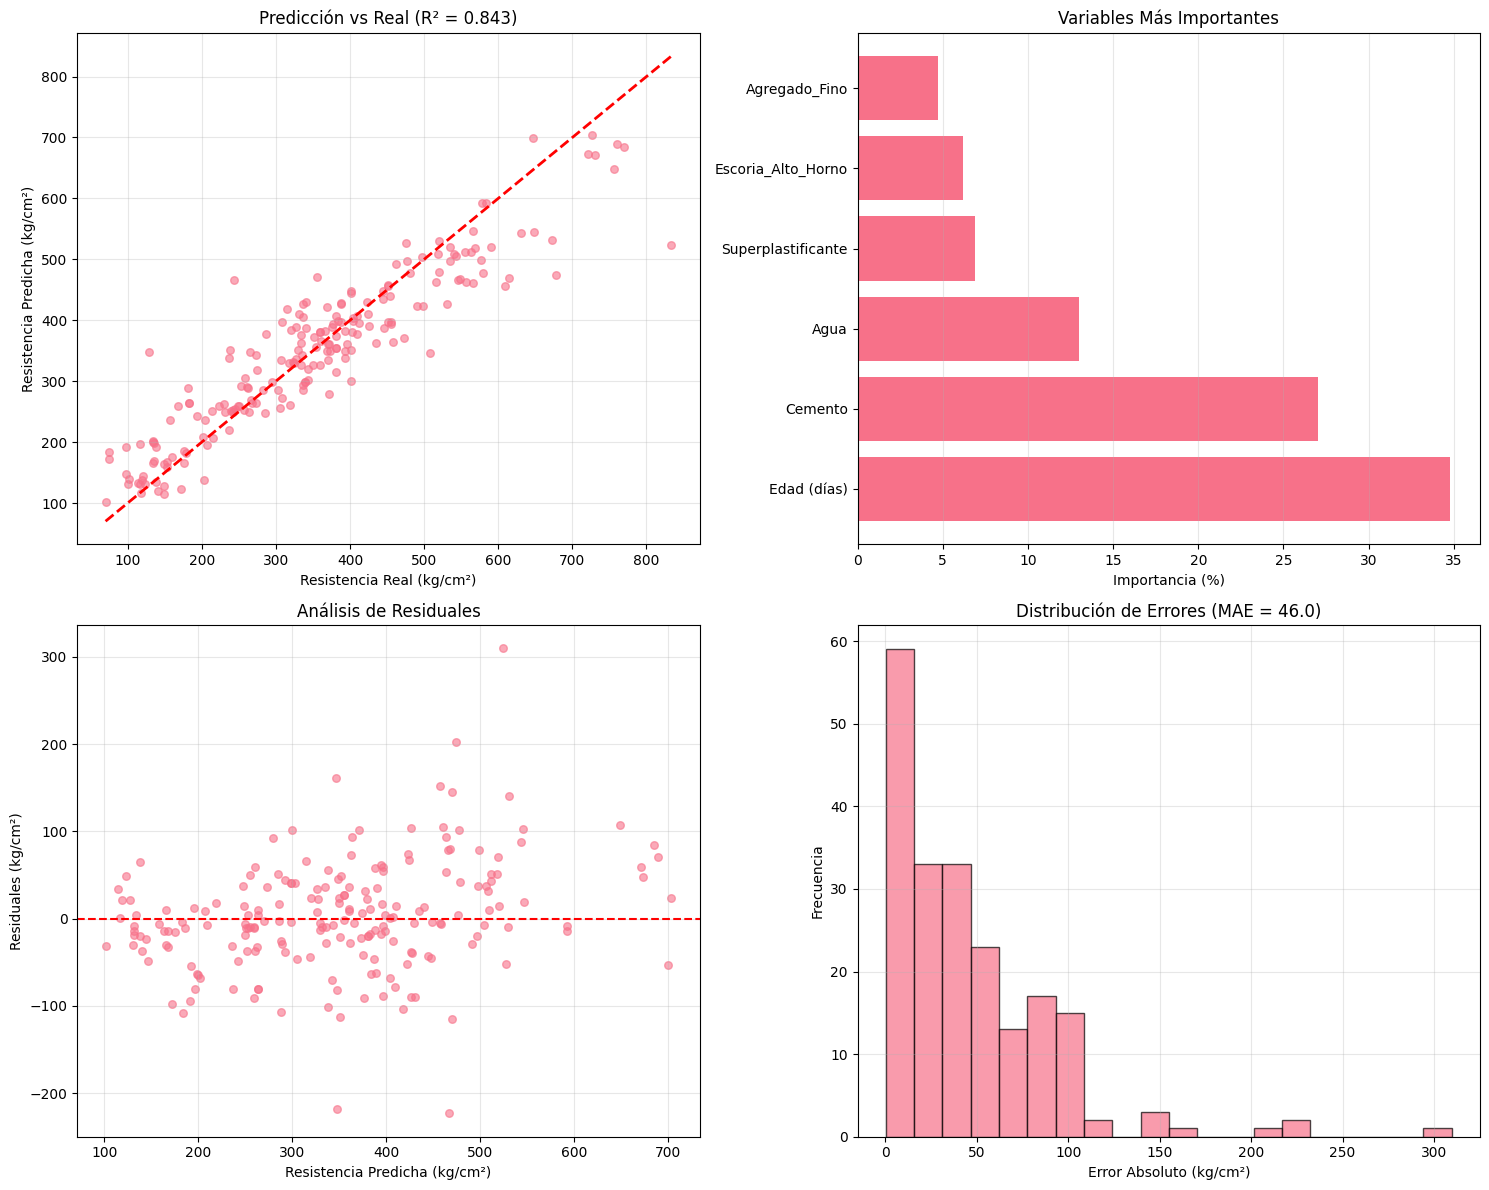

In [39]:
# Crear visualización de performance
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(15, 12))

# 1. Predicho vs Real
ax1.scatter(y_test, y_pred_test, alpha=0.6, s=30)
ax1.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=2)
ax1.set_xlabel('Resistencia Real (kg/cm²)')
ax1.set_ylabel('Resistencia Predicha (kg/cm²)')
ax1.set_title(f'Predicción vs Real (R² = {test_r2:.3f})')
ax1.grid(True, alpha=0.3)

# 2. Feature Importance
top_features = feature_importance.head(6)
ax2.barh(range(len(top_features)), top_features['Importancia_Pct'])
ax2.set_yticks(range(len(top_features)))
ax2.set_yticklabels([var.replace('_kg_m3', '').replace('_dias', ' (días)') for var in top_features['Variable']])
ax2.set_xlabel('Importancia (%)')
ax2.set_title('Variables Más Importantes')
ax2.grid(True, alpha=0.3, axis='x')

# 3. Residuales
residuals = y_test - y_pred_test
ax3.scatter(y_pred_test, residuals, alpha=0.6, s=30)
ax3.axhline(y=0, color='red', linestyle='--')
ax3.set_xlabel('Resistencia Predicha (kg/cm²)')
ax3.set_ylabel('Residuales (kg/cm²)')
ax3.set_title('Análisis de Residuales')
ax3.grid(True, alpha=0.3)

# 4. Distribución de Errores
ax4.hist(np.abs(residuals), bins=20, alpha=0.7, edgecolor='black')
ax4.set_xlabel('Error Absoluto (kg/cm²)')
ax4.set_ylabel('Frecuencia')
ax4.set_title(f'Distribución de Errores (MAE = {test_mae:.1f})')
ax4.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# 9. Implementación del Predictor
## 9.1 Guardar Modelo 

In [43]:
# Guardar modelo entrenado
model_filename = 'modelo_hormigon_ecuador_v1.pkl'
joblib.dump(rf_optimized, model_filename)

# Guardar metadatos
metadata = {
    'modelo_info': {
        'tipo': 'RandomForestRegressor',
        'version': '1.0',
        'fecha_entrenamiento': datetime.now().strftime('%Y-%m-%d %H:%M:%S'),
        'variables_entrada': variables_entrada_es,
        'variable_salida': target_es
    },
    'metricas': {
        'r2_score': float(test_r2),
        'mae_kg_cm2': float(test_mae),
        'cv_score_mean': float(cv_r2.mean()),
        'estabilidad': float(stability)
    }
}

with open('modelo_metadata.json', 'w', encoding='utf-8') as f:
    json.dump(metadata, f, indent=2, ensure_ascii=False)

print(f"✅ Modelo guardado: {model_filename}")
print(f"✅ Metadatos guardados: modelo_metadata.json")

✅ Modelo guardado: modelo_hormigon_ecuador_v1.pkl
✅ Metadatos guardados: modelo_metadata.json


## 9.2 Predictor

In [50]:
def predecir_resistencia():
    """Predictor de resistencia de hormigón"""
    print("PREDICTOR DE RESISTENCIA DE HORMIGÓN - ECUADOR")
    print("="*55)
    print("Cargando modelo entrenado...")
    
    # Cargar modelo
    try:
        modelo = joblib.load('modelo_hormigon_ecuador_v1.pkl')
        print("✅ Modelo cargado exitosamente")
    except FileNotFoundError:
        print("❌ Error: Archivo de modelo no encontrado")
        return
    
    print("\nIngrese los valores en kg/m³ (excepto edad en días):")
    
    # Solicitar inputs con validación
    try:
        cemento = float(input("Cemento (150-500): "))
        escoria = float(input("Escoria Alto Horno (0-300): "))
        ceniza = float(input("Arena (0-200): "))
        agua = float(input("Agua (130-220): "))
        superplast = float(input("Superplastificante (0-25): "))
        grueso = float(input("Agregado Grueso (850-1100): "))
        fino = float(input("Agregado Fino (650-900): "))
        edad = float(input("Edad en días (7-365): "))
        
        # Crear array para predicción
        valores = [cemento, escoria, ceniza, agua, superplast, grueso, fino, edad]
        valores_array = np.array(valores).reshape(1, -1)
        
        # Predicción
        resistencia = modelo.predict(valores_array)[0]
        
        # Calcular W/C ratio
        wc_ratio = agua / cemento
        
        # Mostrar resultado
        print(f"\n🎯 RESULTADO:")
        print(f"Resistencia predicha: {resistencia:.1f} kg/cm²")
        print(f"Relación W/C: {wc_ratio:.3f}")
        
        # Clasificación NEC
        if resistencia < 140:
            clasificacion = "Baja Resistencia"
        elif resistencia < 280:
            clasificacion = "Resistencia Normal"
        elif resistencia < 420:
            clasificacion = "Alta Resistencia"
        else:
            clasificacion = "Ultra Alta Resistencia"
            
        print(f"Clasificación NEC: {clasificacion}")
        
        return resistencia
        
    except ValueError:
        print("❌ Error: Ingrese valores numéricos válidos")
    except Exception as e:
        print(f"❌ Error inesperado: {e}")

# Función para uso programático
def predecir_resistencia_batch(cemento, escoria, ceniza, agua, superplast, grueso, fino, edad):
    """Predicción batch para múltiples casos"""
    modelo = joblib.load('modelo_hormigon_ecuador_v1.pkl')
    valores = np.array([[cemento, escoria, ceniza, agua, superplast, grueso, fino, edad]])
    return modelo.predict(valores)[0]

# Ejemplo de uso
print("PREDICTOR LISTO PARA USAR")
print("Ejecute: predecir_resistencia() para uso interactivo")
predecir_resistencia()

PREDICTOR LISTO PARA USAR
Ejecute: predecir_resistencia() para uso interactivo
PREDICTOR DE RESISTENCIA DE HORMIGÓN - ECUADOR
Cargando modelo entrenado...
✅ Modelo cargado exitosamente

Ingrese los valores en kg/m³ (excepto edad en días):


Cemento (150-500):  200
Escoria Alto Horno (0-300):  200
Arena (0-200):  100
Agua (130-220):  130
Superplastificante (0-25):  25
Agregado Grueso (850-1100):  1000
Agregado Fino (650-900):  700
Edad en días (7-365):  28



🎯 RESULTADO:
Resistencia predicha: 412.6 kg/cm²
Relación W/C: 0.650
Clasificación NEC: Alta Resistencia


C:\Users\FELIX\anaconda3\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


412.6227811533239